In [1]:
#importing
import csv
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
import keras
import pandas as pd
import xgboost as xgb
from scipy.stats import norm

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

2024-08-08 18:21:40.997934: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
XGBoost_distances_all_data = []

/home/ni/Downloads/Geant4 Data/output_nt_Hits_1mm.csv
Average XGBoost Delta X (mm): 0.14620962174267293
Median XGBoost Delta Y (mm): 0.07614374160766851


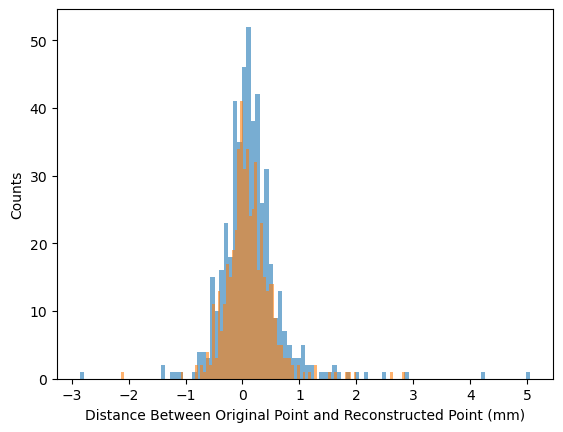

/home/ni/Downloads/Geant4 Data/output_nt_Hits_2mm.csv
Average XGBoost Delta X (mm): 0.14018306478031314
Median XGBoost Delta Y (mm): 0.10252761840820472


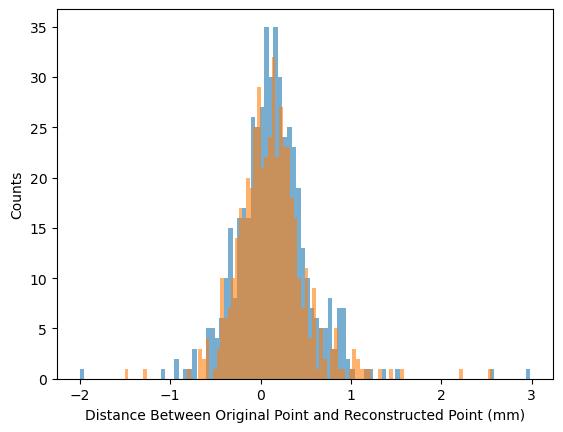

/home/ni/Downloads/Geant4 Data/output_nt_Hits_3mm.csv
Average XGBoost Delta X (mm): 0.11894673944203936
Median XGBoost Delta Y (mm): 0.06823616027832316


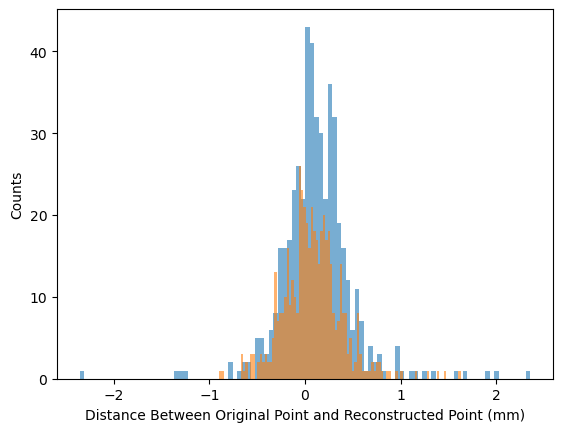

/home/ni/Downloads/Geant4 Data/output_nt_Hits_4mm.csv
Average XGBoost Delta X (mm): 0.16379408824200636
Median XGBoost Delta Y (mm): 0.11290550231933727


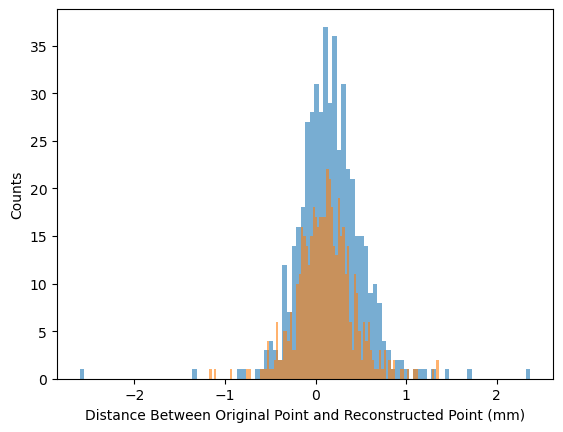

/home/ni/Downloads/Geant4 Data/output_nt_Hits_5mm.csv
Average XGBoost Delta X (mm): 0.19585022441472735
Median XGBoost Delta Y (mm): 0.12934923171997353


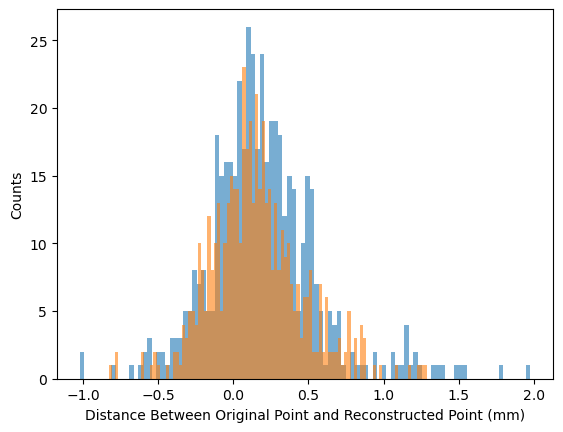

/home/ni/Downloads/Geant4 Data/output_nt_Hits_6mm.csv
Average XGBoost Delta X (mm): 0.1732817373008535
Median XGBoost Delta Y (mm): 0.10240383148193535


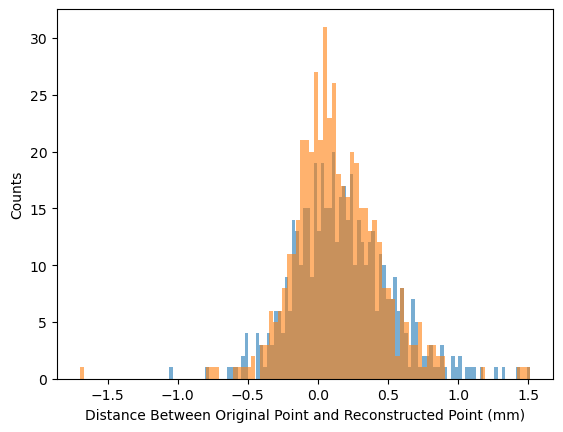

/home/ni/Downloads/Geant4 Data/output_nt_Hits_7mm.csv
Average XGBoost Delta X (mm): 0.2135783727739815
Median XGBoost Delta Y (mm): 0.1264475226402284


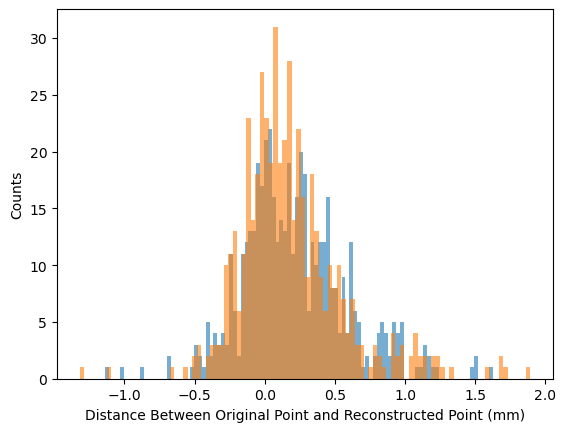

/home/ni/Downloads/Geant4 Data/output_nt_Hits_8mm.csv
Average XGBoost Delta X (mm): 0.25303690602888973
Median XGBoost Delta Y (mm): 0.1395280361175539


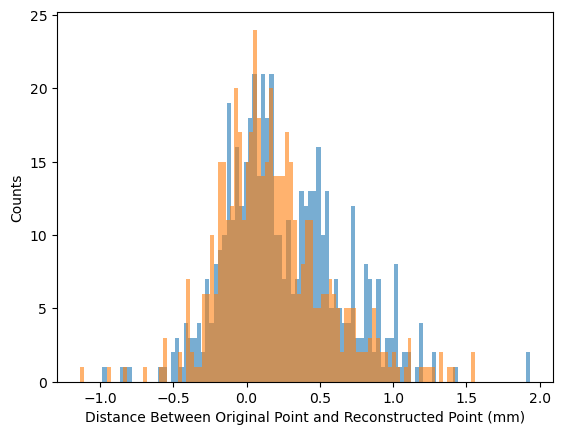

/home/ni/Downloads/Geant4 Data/output_nt_Hits_9mm.csv
Average XGBoost Delta X (mm): 0.2415948178478508
Median XGBoost Delta Y (mm): 0.17048492431640677


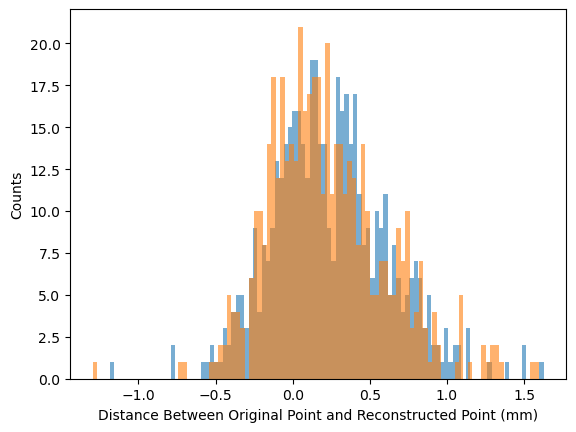

/home/ni/Downloads/Geant4 Data/output_nt_Hits_10mm.csv
Average XGBoost Delta X (mm): 0.2381891005482459
Median XGBoost Delta Y (mm): 0.1335007548332209


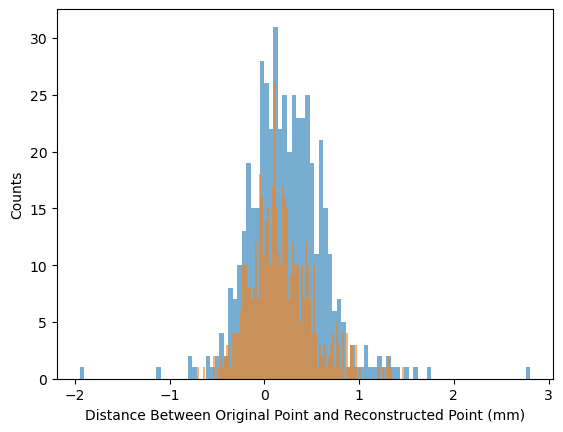

/home/ni/Downloads/Geant4 Data/output_nt_Hits_11mm.csv
Average XGBoost Delta X (mm): 0.20601549213258086
Median XGBoost Delta Y (mm): 0.15503976345062237


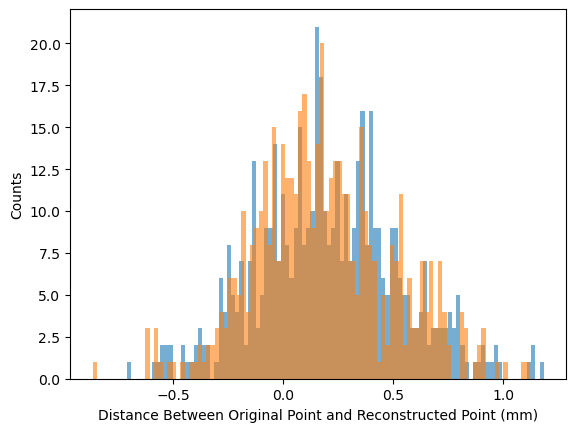

/home/ni/Downloads/Geant4 Data/output_nt_Hits_12mm.csv
Average XGBoost Delta X (mm): 0.19415176144359286
Median XGBoost Delta Y (mm): 0.12598159313202076


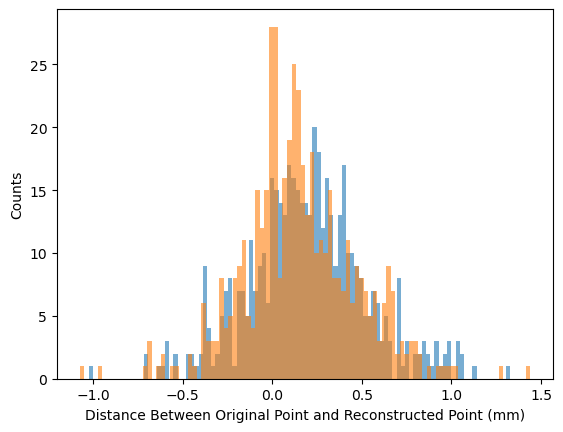

/home/ni/Downloads/Geant4 Data/output_nt_Hits_13mm.csv
Average XGBoost Delta X (mm): 0.18189109119567745
Median XGBoost Delta Y (mm): 0.15556774139404578


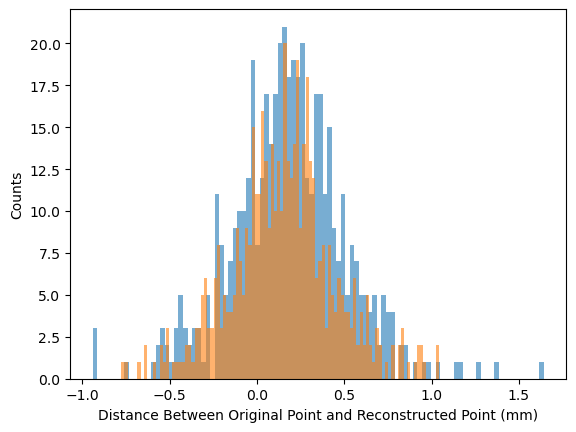

/home/ni/Downloads/Geant4 Data/output_nt_Hits_14mm.csv
Average XGBoost Delta X (mm): 0.18099486792156086
Median XGBoost Delta Y (mm): 0.12209963798523038


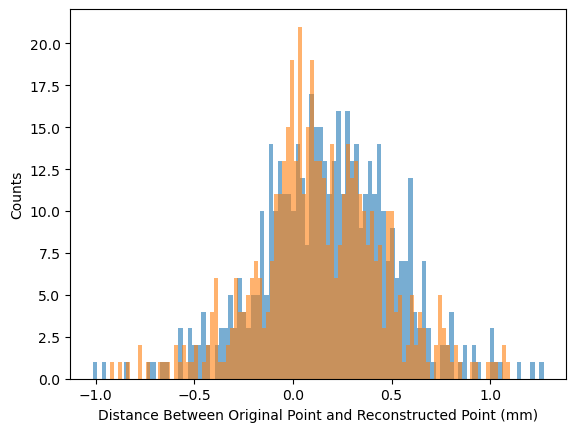

/home/ni/Downloads/Geant4 Data/output_nt_Hits_15mm.csv
Average XGBoost Delta X (mm): 0.20954344251022156
Median XGBoost Delta Y (mm): 0.18038406372070598


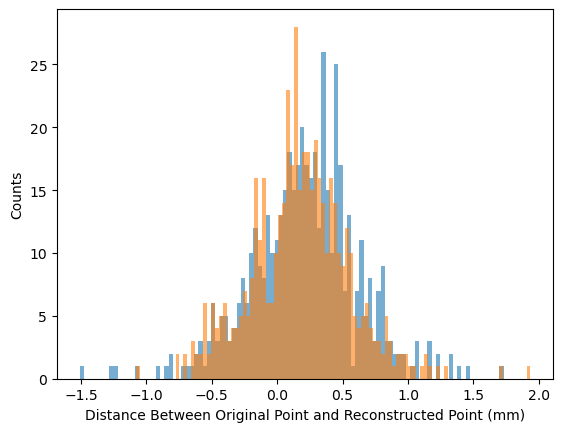

/home/ni/Downloads/Geant4 Data/output_nt_Hits_25mm.csv
Average XGBoost Delta X (mm): 0.5526166675314413
Median XGBoost Delta Y (mm): 0.48022050857544224


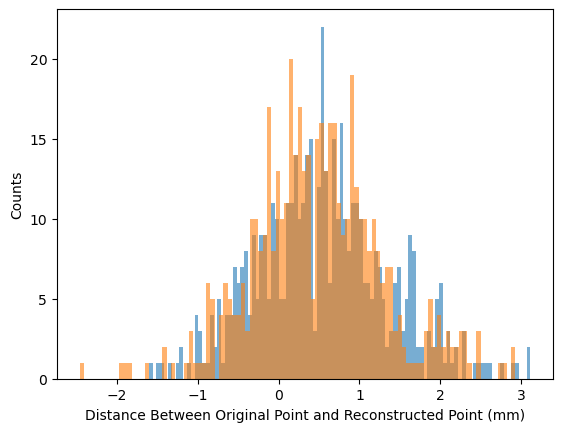

/home/ni/Downloads/Geant4 Data/output_nt_Hits_45mm.csv
Average XGBoost Delta X (mm): 2.232385222914972
Median XGBoost Delta Y (mm): 1.648357009887695


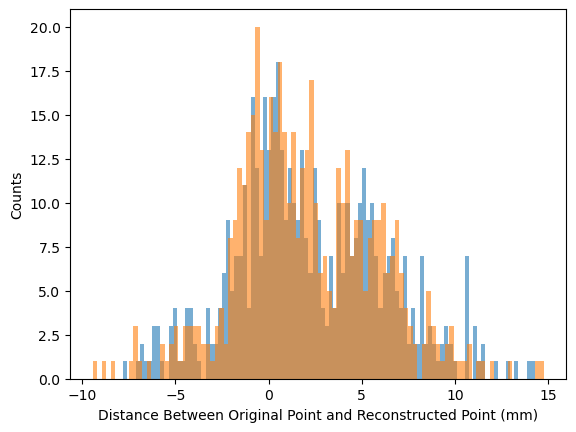

In [3]:
numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 25, 45]
for q in numbers:
    #getting X data
    #file = open('/content/drive/MyDrive/output_nt_Hits_1_layer_5mm.csv')
    file = open('/home/ni/Downloads/Geant4 Data/output_nt_Hits_' + str(q) + 'mm.csv')
    print('/home/ni/Downloads/Geant4 Data/output_nt_Hits_' + str(q) + 'mm.csv')
    csvreader = csv.reader(file)
    #first 13 rows aren't needed
    line_count = 0;
    original_X = []
    for row in csvreader:
      if line_count >= 13:
        original_X.append([int(i) for i in row])
      line_count += 1
    
    
    #getting Y data
    original_y = []
    for i in range(-122, 1):
      for j in range(-122, 1):
        original_y.append([i*0.2, j*0.2])
    
    #reconstructing
    num_X = np.array(original_X).reshape(123,123,9)
    num_y = np.array(original_y).reshape(123,123,2)
    bottom_right_X = []
    bottom_right_y = []
    for i in range(-122, 0):
      for j in range(-122, 1):
        tmp_X = copy.deepcopy(num_X[i+122][j+122])
        tmp_y = copy.deepcopy(num_y[i+122][j+122])
        #mirroring
        tmp_y[0] = -tmp_y[0]
        for k in range(3):
          tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
        bottom_right_X.append(tmp_X)
        bottom_right_y.append(tmp_y)
    
    bottom_right_X = np.array(bottom_right_X).reshape(122,123,9)
    bottom_right_y = np.array(bottom_right_y).reshape(122,123,2)
    
    top_left_X = []
    top_left_y = []
    for i in range(-122, 1):
      for j in range(-122, 0):
        tmp_X = copy.deepcopy(num_X[i+122][j+122])
        tmp_y = copy.deepcopy(num_y[i+122][j+122])
        #mirroring
        tmp_y[1] = -tmp_y[1]
        for k in range(3):
          tmp_X[k], tmp_X[k+3*2] = tmp_X[k+3*2], tmp_X[k]
        top_left_X.append(tmp_X)
        top_left_y.append(tmp_y)
    
    top_left_X = np.array(top_left_X).reshape(123,122,9)
    top_left_y = np.array(top_left_y).reshape(123,122,2)
    
    top_right_X = []
    top_right_y = []
    for i in range(-122, 0):
      for j in range(-122, 0):
        tmp_X = copy.deepcopy(top_left_X[i+122][j+122])
        tmp_y = copy.deepcopy(top_left_y[i+122][j+122])
        #mirroring
        tmp_y[0] = -tmp_y[0]
        for k in range(3):
          tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
        top_right_X.append(tmp_X)
        top_right_y.append(tmp_y)
    
    top_right_X = np.array(top_right_X).reshape(122,122,9)
    top_right_y = np.array(top_right_y).reshape(122,122,2)
    
    #converting to numpy array
    X = np.concatenate((num_X.reshape(15129, 9), bottom_right_X.reshape(15006, 9), top_left_X.reshape(15006, 9), top_right_X.reshape(14884, 9)))
    y = np.concatenate((num_y.reshape(15129, 2), bottom_right_y.reshape(15006, 2), top_left_y.reshape(15006, 2), top_right_y.reshape(14884, 2)))

    #training
    XGBoost_distances = np.zeros((245,245,2))
    scaler = StandardScaler()
    for k in range(10):
        X_XGBoost = scaler.fit_transform(X)
        X_train, X_val, y_train, y_val = train_test_split(X_XGBoost, y, test_size=0.3)
    
        model = xgb.XGBRegressor()
        model.fit(X_train, y_train)
        
        #finding distances
        yhat = model.predict(X_XGBoost)
        for i in range(len(X)):
            #finding average of each point
            XGBoost_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)][0] = k / (k + 1) * XGBoost_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)][0] + 1 / (k + 1) * (yhat[i][0] - y[i][0])
            XGBoost_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)][1] = k / (k + 1) * XGBoost_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)][1] + 1 / (k + 1) * (yhat[i][1] - y[i][1])
    
    print("Average XGBoost Delta X (mm): " + str(np.average(XGBoost_distances[:][:][0])))
    print("Median XGBoost Delta Y (mm): " + str(np.median(XGBoost_distances[:][:][1])))

    plt.hist(XGBoost_distances[:][:][0].ravel(), bins=100, alpha=0.6, label='delta X')
    plt.hist(XGBoost_distances[:][:][1].ravel(), bins=100, alpha=0.6, label='delta Y')
    plt.xlabel('Distance Between Original Point and Reconstructed Point (mm)')
    plt.ylabel('Counts')
    plt.show()
    
    #getting data setup for colormap for XGBoost
    #yhat_temp = model.predict(X)
    #xaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
    #yaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
    #creating colormap
    #plt.figure(figsize=(8, 6))
    #plt.pcolormesh(xaxis, yaxis, XGBoost_distances, shading='auto', cmap='viridis')
    
    # Add color bar
    #plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')
    
    # Add labels and title
    #plt.xlabel('X (mm)')
    #plt.ylabel('Y (mm)')
    #plt.title('Accuracy of XGBoost')
    
    # Display the plot
    #plt.show()
    
    XGBoost_distances_all_data.append(XGBoost_distances)

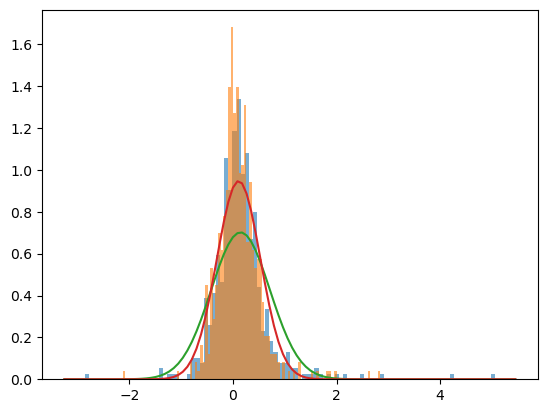

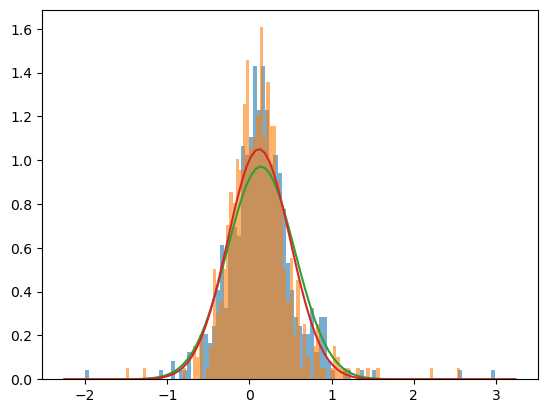

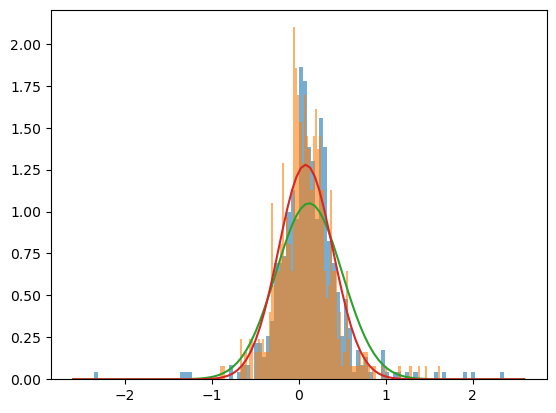

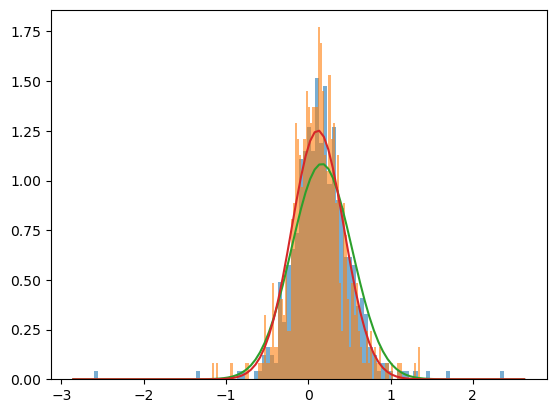

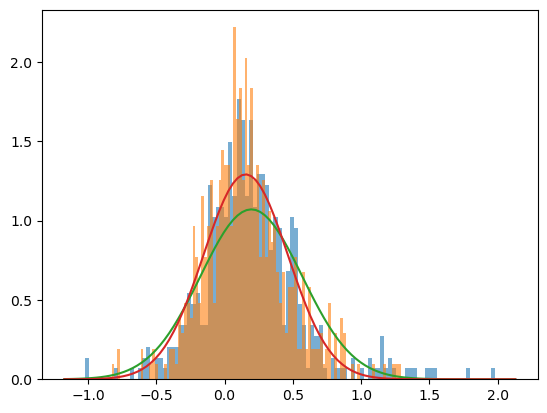

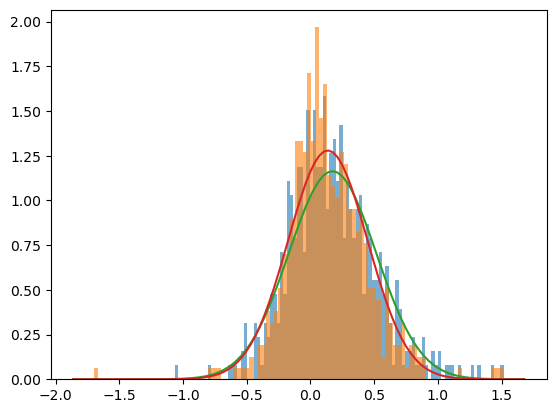

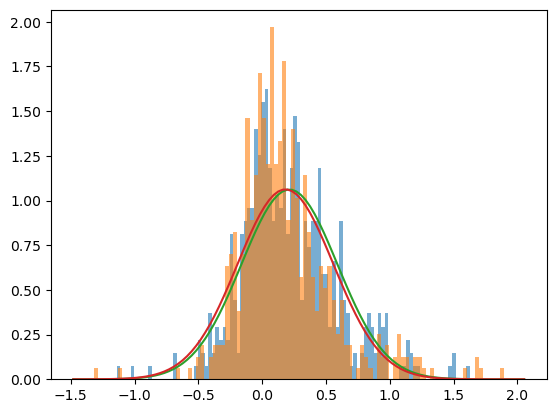

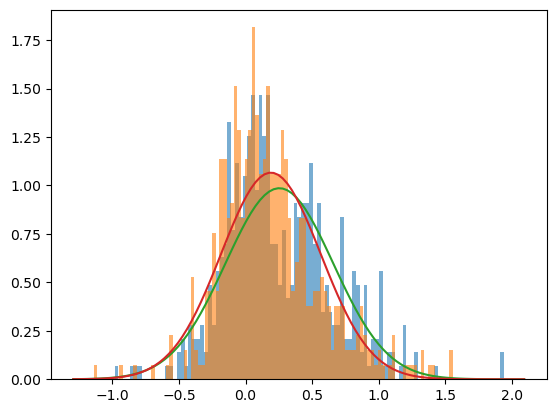

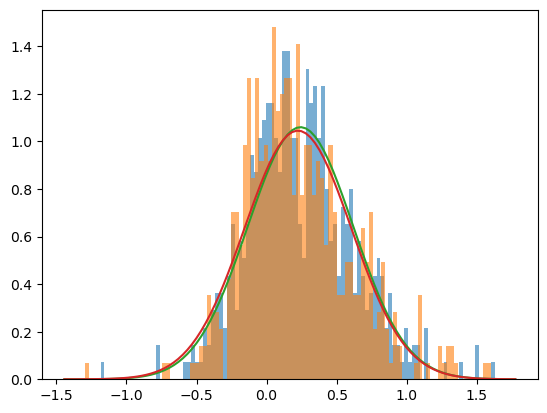

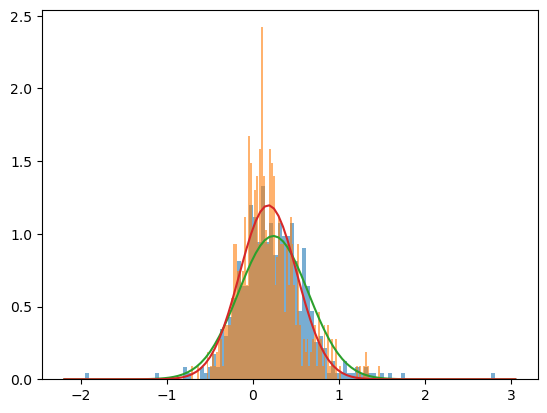

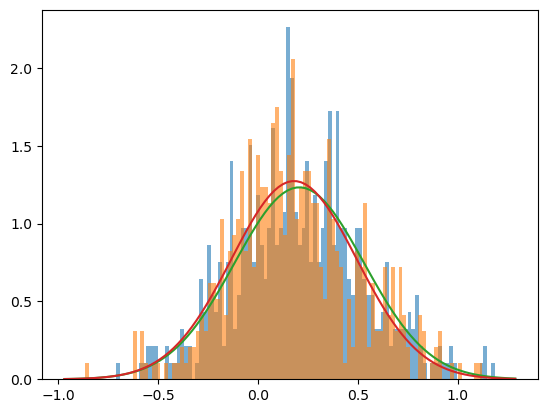

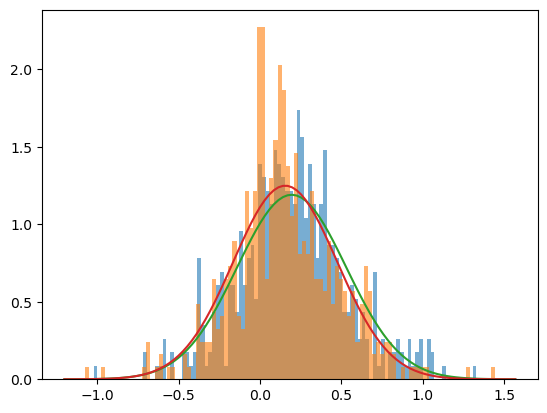

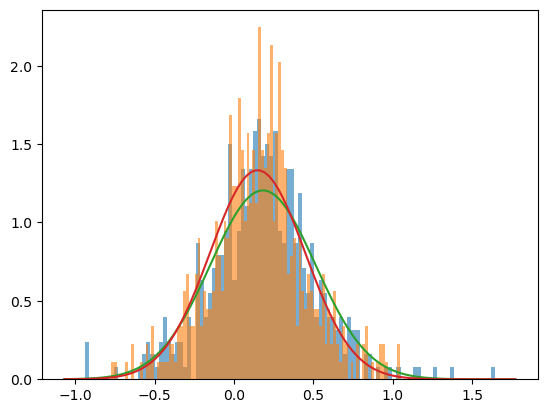

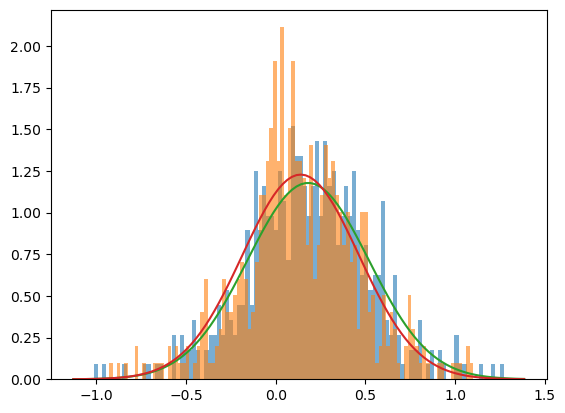

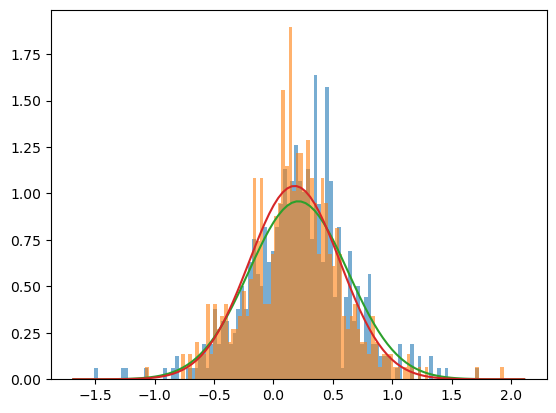

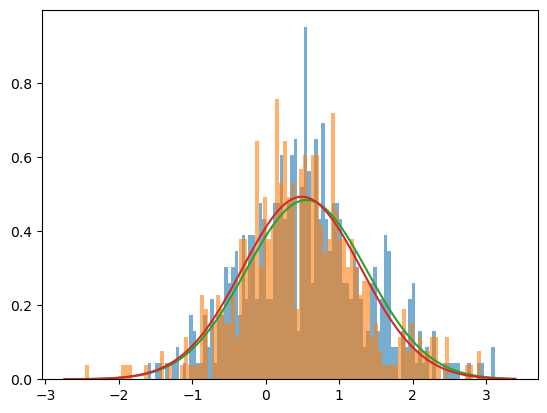

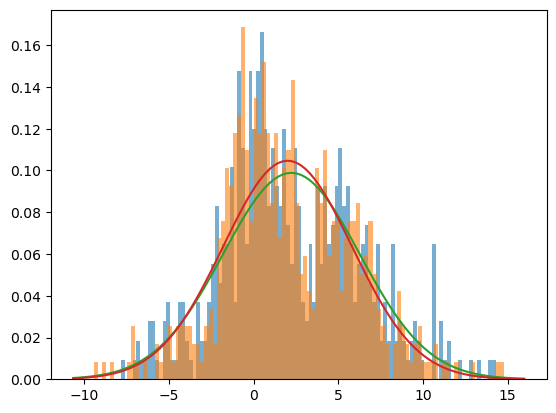

In [4]:
standard_deviations = []
means = []

for element in XGBoost_distances_all_data:
    meanx,stdx=norm.fit(element[:][:][0].ravel())
    meany,stdy=norm.fit(element[:][:][1].ravel())
    standard_deviations.append([stdx, stdy])
    means.append([meanx, meany])
    plt.hist(element[:][:][0].ravel(), bins=100, alpha=0.6, label='delta X', density=True)
    plt.hist(element[:][:][1].ravel(), bins=100, alpha=0.6, label='delta Y', density=True)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    xy = norm.pdf(x, meanx, stdx)
    yy = norm.pdf(x, meany, stdy)
    plt.plot(x, xy)
    plt.plot(x, yy)
    plt.show()

In [5]:
print([standard_deviations[9][0]*2.355, standard_deviations[9][1]*2.355])

[0.9530729767226572, 0.7849278887781665]


In [6]:
XGBoost_distances_all_data_np = np.array(XGBoost_distances_all_data)
np.savetxt('XGBoost_distances_delta.csv', XGBoost_distances_all_data_np.reshape(XGBoost_distances_all_data_np.shape[0], -1))

#print(XGBoost_distances_all_data_np.shape)